In [1]:
# packages

import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.optimize import fsolve
from sympy import symbols, Eq, solve, I, cos, exp, pi
import os
os.chdir('C:\\Users\\nicol\\Desktop\\pythonfiles\\Aeroelasticity\\assignment1')  # change this to your directory


In [2]:
# functions

def compute_matrices(theta_blade, theta_yaw, theta_tilt, theta_cone):

    a1 = (  [1,0,0],
            [0, np.cos(theta_yaw), np.sin(theta_yaw)],
            [0, -np.sin(theta_yaw), np.cos(theta_yaw)])
    a2 = (  [np.cos(theta_tilt), 0, -np.sin(theta_tilt)],
            [0, 1, 0],
            [np.sin(theta_tilt), 0, np.cos(theta_tilt)])
    a12 = np.matmul(a2, a1)
    a21 = np.transpose(a12)
    
    a23 = ( [np.cos(theta_blade), np.sin(theta_blade), 0],
            [-np.sin(theta_blade), np.cos(theta_blade), 0],
            [0, 0, 1])
    a34 = ( [np.cos(theta_cone), 0, -np.sin(theta_cone)],
            [0, 1, 0],
            [np.sin(theta_cone), 0, np.cos(theta_cone)])
    a14 = np.matmul(np.matmul(a34,a23), a12)
    a41 = np.transpose(a14)

    return a21, a23, a41 

def compute_position(a21, a41, H, Ls, radius):
    
    rt = np.transpose([H,0,0])
    rs = np.matmul(a21, np.transpose([0,0,-Ls]))
    rb = np.matmul(a41, np.transpose([radius,0,0]))
    position = rt + rs + rb
    return position

def compute_tower_radius(x):
    if x <= H:
        a = a0
    else:
        a = 0
    return a



# interpolate airfoil

files=[ 'FFA-W3-241.txt',
        'FFA-W3-301.txt',
        'FFA-W3-360.txt',
        'FFA-W3-480.txt',
        'FFA-W3-600.txt',
        'cylinder.txt']

#Initializing tables    
cl_tab=np.zeros([105,6])
cd_tab=np.zeros([105,6])
cm_tab=np.zeros([105,6])
aoa_tab=np.zeros([105,])
misc_1_tab=np.zeros([105,6])
misc_2_tab=np.zeros([105,6])
misc_3_tab=np.zeros([105,6])

#Reading of tables. Only do this once at startup of simulation
for i in range(np.size(files)):
    aoa_tab[:],cl_tab[:,i],cd_tab[:,i],cm_tab[:,i],misc_1_tab[:,i],misc_2_tab[:,i],misc_3_tab[:,i] = np.loadtxt(files[i], skiprows=0).T

# Thickness of the airfoils considered
# NOTE THAT IN PYTHON THE INTERPOLATION REQUIRES THAT THE VALUES INCREASE IN THE VECTOR!

thick_prof=np.zeros(6)
thick_prof[0]=24.1
thick_prof[1]=30.1
thick_prof[2]=36
thick_prof[3]=48
thick_prof[4]=60
thick_prof[5]=100

def force_coeffs_10MW(angle_of_attack,thick,aoa_tab,cl_tab,cd_tab,cm_tab):
    
    cl_aoa=np.zeros([1,6])
    cd_aoa=np.zeros([1,6])
    cm_aoa=np.zeros([1,6])
    
    #Interpolate to current angle of attack:
    for i in range(np.size(files)):
        cl_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cl_tab[:,i])
        cd_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cd_tab[:,i])
        cm_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cm_tab[:,i])
    
    #Interpolate to current thickness:
    cl=np.interp (thick,thick_prof,cl_aoa[0,:])
    cd=np.interp (thick,thick_prof,cd_aoa[0,:])
    cm=np.interp (thick,thick_prof,cm_aoa[0,:])
    
    return cl, cd, cm 


In [62]:
# data

ac=1/3
eps=1e-8
max_iteration=100000
B=3
rho=1.225
R=89.17

blade=pd.read_csv('bladedat.txt',delimiter='\t',header=None,names=['r','beta','c','t_perc'])
r_array = blade['r']

theta_pitch = 0

num =1000
deltat = 0.01

# angles
theta_yaw = 0
theta_tilt = 0
theta_cone = 0

# wind
nu = 0.0
V0 = 9

omega = 0.62
H = 119
Ls = 7.1
a0 = 0



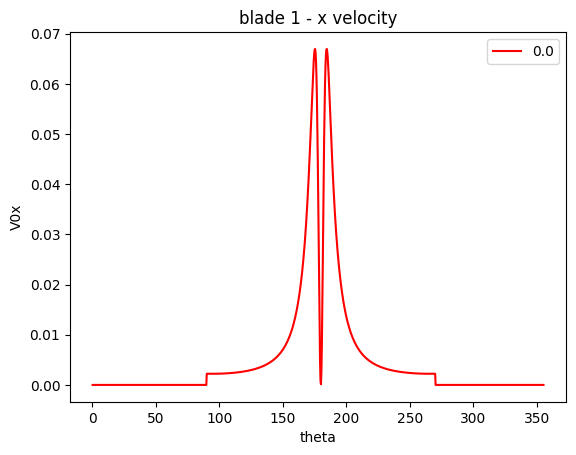

In [22]:
# BEM one blade


def BEM():

    
    theta_blade1_array = []

    theta_blade1_old = 0

    Wy_old = np.zeros(len(r_array[:-1]))
    Wz_old = np.zeros(len(r_array[:-1]))

    Wy_qs = np.zeros(len(r_array[:-1]))
    Wz_qs = np.zeros(len(r_array[:-1]))
    

    for n in range(0,num):

        # time
        time = n*deltat

        # angles
        theta_blade1 = theta_blade1_old + omega*deltat
        #theta_blade2 = theta_blade1 + 2*np.pi/3
        #theta_blade3 = theta_blade2 + 4*np.pi/3
        theta_blade1_array.append(theta_blade1)

        # running only one blade

        a21_1, a23_1, a41_1 = compute_matrices(theta_blade1, theta_yaw, theta_tilt, theta_cone)

        
        # position
        for i in range(len(r_array[:-1])):
        
            r = blade['r'][i]
            beta = np.deg2rad(blade['beta'][i])
            c = blade['c'][i]
            
            thick_perc = blade['t_perc'][i]     # thickness of blade
            r_1 = compute_position(a21_1, a41_1, H, Ls, r)

            # shear
            V0x = V0*(r_1[0] / H)**nu

            # tower
            y = r_1[1]
            z = r_1[2]
            r = np.sqrt(y**2 + z**2)
            a_tower = compute_tower_radius(r_1[0])

            Vr =     z/r * V0x * (1 - (a_tower/r)**2)
            Vtheta = y/r * V0x * (1 + (a_tower/r)**2)

            Vx = 0
            Vz =  z/r * Vr + y/r * Vtheta
            Vy =  y/r * Vr - z/r * Vtheta

            # total velocity
            a14_1 = np.transpose(a41_1)
            V0_1_1 = [Vx, Vy, Vz]
            V0_4_1 = np.matmul(a14_1, np.transpose(V0_1_1))  


            # new stuff
            
            Vrel_y = V0_4_1[1] + Wy_old[i] - omega*r*np.cos(theta_cone)
            Vrel_z = V0_4_1[2] + Wz_old[i]

            phi = np.arctan(- Vrel_z/Vrel_y)
            alpha = phi - (beta + theta_pitch)

            Cl,Cd,Cm = force_coeffs_10MW(np.rad2deg(alpha), thick_perc,aoa_tab,cl_tab,cd_tab,cm_tab)

            Vrel = np.sqrt(Vrel_y**2 + Vrel_z**2)

            V0_local = np.linalg.norm(V0_4_1)  # magnitude of local wind considering shear, tower
            
            a = - Wz_old[i]/ V0            # check what happens with V0_local => is a too much spiky?
            if a <= 1/3:
                fg = 1
            else:
                fg = 1/4* (5-3*a)
            
            F = 2/np.pi * np.arccos(np.exp(-B/2 * (R-r)/(r*np.sin(np.abs(phi)))))

            l = 0.5*rho*Vrel**2 * c * Cl
            d = 0.5*rho*Vrel**2 * c * Cd

            pz = l*np.cos(phi) + d*np.sin(phi)
            py = l*np.sin(phi) - d*np.cos(phi)

            Wz_qs[i] = (- B * l * np.cos(phi)) / (4*np.pi * rho * r * F * np.sqrt(V0_4_1[1]**2 + (V0_4_1[2] + fg*Wz_old[i])**2))
            Wy_qs[i] = (- B * l * np.sin(phi)) / (4*np.pi * rho * r * F * np.sqrt(V0_4_1[1]**2 + (V0_4_1[2] + fg*Wz_old[i])**2))

            Wz_old[i] = Wz_qs[i]
            Wy_old[i] = Wy_qs[i]


        V0_1array.append(V0_4_1)

        
        
        theta_blade1_old = theta_blade1
    
    V0x_1 = [arr[0] for arr in V0_1array]
    V0y_1 = [arr[1] for arr in V0_1array]
    V0z_1 = [arr[2] for arr in V0_1array]

    return V0x_1, V0y_1, V0z_1, time_array, theta_blade1_array

V0x_1_a, V0y_1_a, V0z_1_a, time_array, theta_blade1_array = BEM()



plt.figure(1)
plt.plot(np.rad2deg(theta_blade1_array), V0x_1_a, color='r', label=np.rad2deg(theta_yaw))
plt.legend()
plt.xlabel('theta')
plt.ylabel('V0x')
plt.title('blade 1 - x velocity')
plt.show()



In [60]:
# BEM 3 blades


def BEM():

    theta_blade1_array = []

    theta_blade1_old = 0

    Wy_old = np.zeros(len(r_array[:-1]))
    Wz_old = np.zeros(len(r_array[:-1]))

    Wy_qs = np.zeros(len(r_array[:-1]))
    Wz_qs = np.zeros(len(r_array[:-1]))

    Wy = np.zeros(len(r_array[:-1]))
    Wz = np.zeros(len(r_array[:-1]))

    P = []
    T = []
    time_array = []
    

    for n in range(0,num):

        # time
        time = n*deltat
        time_array.append(time)

        # angles

        theta_blade1 = theta_blade1_old + omega*deltat
        theta_blade2 = theta_blade1 + 2*np.pi/3
        theta_blade3 = theta_blade1 + 4*np.pi/3

        theta_blade_array = [theta_blade1, theta_blade2, theta_blade3]

        #theta_blade1_array.append(theta_blade1)

        P_time = []
        T_time = []

        for j in range(B):

            a21, a23, a41 = compute_matrices(theta_blade_array[j], theta_yaw, theta_tilt, theta_cone)

            dP_array = []
            dT_array = []

            # position
            for i in range(len(r_array[:-1])):
            
                r = blade['r'][i]
                beta = np.deg2rad(blade['beta'][i])
                c = blade['c'][i]
                
                thick_perc = blade['t_perc'][i]     # thickness of blade
                r_1 = compute_position(a21, a41, H, Ls, r)

                # shear
                V0x = V0*(r_1[0] / H)**nu

                # tower
                y = r_1[1]
                z = r_1[2]
                r = np.sqrt(y**2 + z**2)
                a_tower = compute_tower_radius(r_1[0])

                Vr =     z/r * V0x * (1 - (a_tower/r)**2)
                Vtheta = y/r * V0x * (1 + (a_tower/r)**2)

                Vx = 0
                Vz =  z/r * Vr + y/r * Vtheta
                Vy =  y/r * Vr - z/r * Vtheta

                # total velocity
                a14 = np.transpose(a41)
                V0_1_1 = [Vx, Vy, Vz]
                V0_4_1 = np.matmul(a14, np.transpose(V0_1_1))  


                # new stuff
                
                Vrel_y = V0_4_1[1] + Wy_old[i] - omega*r*np.cos(theta_cone)
                Vrel_z = V0_4_1[2] + Wz_old[i]

                phi = np.arctan(- Vrel_z/Vrel_y)
                alpha = phi - (beta + theta_pitch)

                Cl,Cd,Cm = force_coeffs_10MW(np.rad2deg(alpha), thick_perc,aoa_tab,cl_tab,cd_tab,cm_tab)

                Vrel = np.sqrt(Vrel_y**2 + Vrel_z**2)

                V0_local = np.linalg.norm(V0_4_1)  # magnitude of local wind considering shear, tower
                
                a = - Wz_old[i]/ V0            # check what happens with V0_local => is a too much spiky?
                if a <= 1/3:
                    fg = 1
                else:
                    fg = 1/4* (5-3*a)
                
                F = 2/np.pi * np.arccos(np.exp(-B/2 * (R-r)/(r*np.sin(np.abs(phi)))))

                l = 0.5*rho*Vrel**2 * c * Cl
                d = 0.5*rho*Vrel**2 * c * Cd

                pz = l*np.cos(phi) + d*np.sin(phi)
                py = l*np.sin(phi) - d*np.cos(phi)

                Wz_qs[i] = (- B * l * np.cos(phi)) / (4*np.pi * rho * r * F * np.sqrt(V0_4_1[1]**2 + (V0_4_1[2] + fg*Wz_old[i])**2))
                Wy_qs[i] = (- B * l * np.sin(phi)) / (4*np.pi * rho * r * F * np.sqrt(V0_4_1[1]**2 + (V0_4_1[2] + fg*Wz_old[i])**2))


                tau = 2*R/V0

                Wz = Wz_qs[i] + (Wz_old[i] - Wz_qs[i])*np.exp(-deltat/tau)
                Wy = Wy_qs[i] + (Wy_old[i] - Wy_qs[i])*np.exp(-deltat/tau)

                # this must be changed
                Wz_old[i] = Wz
                Wy_old[i] = Wy

                # power and thrust
                dP = omega*py*r
                dT = pz

                dP_array.append(dP)
                dT_array.append(dT)


            P_blade = integrate.simps(y=dP_array, x=r_array[:-1])
            T_blade = integrate.simps(y=dT_array, x=r_array[:-1])
            
            P_time.append(P_blade)
            T_time.append(T_blade)
        
        P.append(P_time)
        T.append(T_time)


        theta_blade1_old = theta_blade1


    return np.array(P), np.array(T), np.array(time_array)

P, T , time_array= BEM()



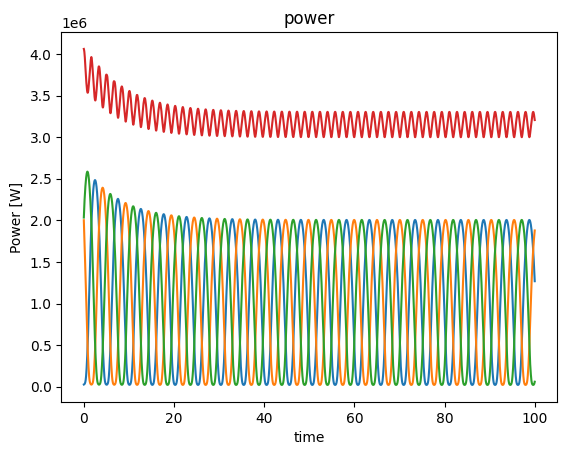

In [61]:

plt.plot(time_array, P[:,0], label='blade1')
plt.plot(time_array, P[:,1], label='blade2')
plt.plot(time_array, P[:,2], label='blade3')
plt.plot(time_array, (P[:,0]+P[:,1]+P[:,2]), label='all')
plt.title('power')
plt.xlabel('time')
plt.ylabel('Power [W]')
plt.show()

Text(0.5, 1.0, 'blade 1 - z velocity')

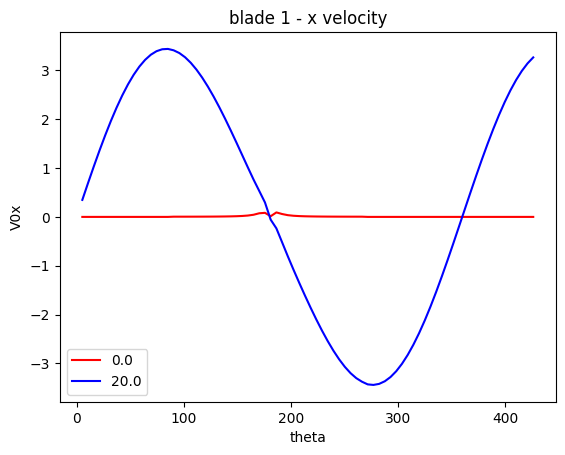

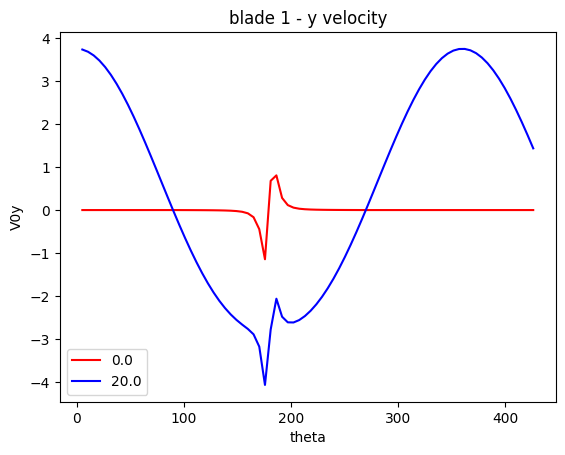

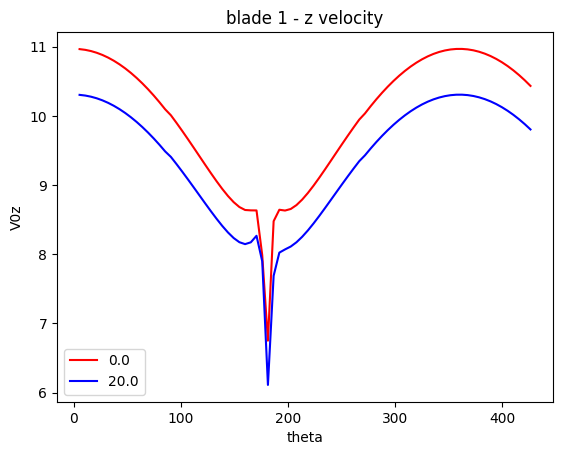

In [18]:
# ex 4 and 5

H = 119
Ls = 7.1
R = 89.15
theta_tilt = np.deg2rad(0)
nu = 0.2
V0 = 10

num =80
deltat = 0.15

omega = 0.62
radius = 70

a0 = 3.32
theta_cone = 0

theta_yaw_a = 0
theta_yaw_b = np.deg2rad(20)

def compute_tower_radius(x):
    if x <= H:
        a = a0
    else:
        a = 0
    return a


def compute_velocity_shear_tower(num, theta_yaw):
    time_array = []
    theta_blade1_array = []
    V0_1array = []

    theta_blade1 = 0

    for n in range(0,num):

        # time
        time = n*deltat
        time_array.append(time)

        # angles
        theta_blade1_new = theta_blade1 + omega*deltat
        theta_blade1_array.append(theta_blade1_new)

        a21_1, a23_1, a41_1 = compute_matrices(theta_blade1_new, theta_yaw, theta_tilt, theta_cone)

        # position
        r_1 = compute_position(a21_1, a41_1, H, Ls, radius)

        # shear
        V0x = V0*(r_1[0] / H)**nu

        # tower
        y = r_1[1]
        z = r_1[2]
        r = np.sqrt(y**2 + z**2)
        a = compute_tower_radius(r_1[0])

        Vr =     z/r * V0x * (1 - (a/r)**2)
        Vtheta = y/r * V0x * (1 + (a/r)**2)

        Vx = 0
        Vz =  z/r * Vr + y/r * Vtheta
        Vy =  y/r * Vr - z/r * Vtheta

        # total velocity
        a14_1 = np.transpose(a41_1)
        V0_1_1 = [Vx, Vy, Vz]
        V0_4_1 = np.dot(a14_1, V0_1_1)  
        V0_1array.append(V0_4_1)

        theta_blade1 = theta_blade1_new
    
    V0x_1 = [arr[0] for arr in V0_1array]
    V0y_1 = [arr[1] for arr in V0_1array]
    V0z_1 = [arr[2] for arr in V0_1array]

    return V0x_1, V0y_1, V0z_1, time_array, theta_blade1_array

V0x_1_a, V0y_1_a, V0z_1_a, time_array, theta_blade1_array = compute_velocity_shear_tower(num=num, theta_yaw=theta_yaw_a)
V0x_1_b, V0y_1_b, V0z_1_b, time_array, theta_blade1_array = compute_velocity_shear_tower(num=num, theta_yaw=theta_yaw_b)


plt.figure(1)
plt.plot(np.rad2deg(theta_blade1_array), V0x_1_a, color='r', label=np.rad2deg(theta_yaw_a))
plt.plot(np.rad2deg(theta_blade1_array), V0x_1_b, color='b', label=np.rad2deg(theta_yaw_b))
plt.legend()
plt.xlabel('theta')
plt.ylabel('V0x')
plt.title('blade 1 - x velocity')

plt.figure(2)
plt.plot(np.rad2deg(theta_blade1_array), V0y_1_a, color='r', label=np.rad2deg(theta_yaw_a))
plt.plot(np.rad2deg(theta_blade1_array), V0y_1_b, color='b', label=np.rad2deg(theta_yaw_b))
plt.legend()
plt.xlabel('theta')
plt.ylabel('V0y')
plt.title('blade 1 - y velocity')

plt.figure(3)
plt.plot(np.rad2deg(theta_blade1_array), V0z_1_a, color='r', label=np.rad2deg(theta_yaw_a))
plt.plot(np.rad2deg(theta_blade1_array), V0z_1_b, color='b', label=np.rad2deg(theta_yaw_b))
plt.legend()
plt.xlabel('theta')
plt.ylabel('V0z')
plt.title('blade 1 - z velocity')
